ユーザベースの協調フィルタリング

ユーザの嗜好の類似度をベースにレコメンド

ユーザの評価を元に，ユーザ軸で類似度を計算（ユーザ類似度のディクショナリは持たない）．よって非常にシンプル．  
よってデータセットが頻繁に変更されても対応できる．  
しかし，データセットが巨大になると計算が遅くなる．

In [9]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import sparse
from scipy.spatial.distance import cosine # cosine類似度に基づくcosine距離（類似していると数値が小さくなる）
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
# df.max()

user_id            943
item_id           1682
rating               5
timestamp    893286638
dtype: int64

In [10]:
df_ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', header=None, 
                 names=['user_id', 'movie_id', 'rating', 'timestamp'] ,engine='python')

In [11]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


ユーザ×アイテム　行列を作成する

In [5]:
df_ratings.rename(columns={'movie_id': 'item_id'}, inplace=True)

In [7]:
shape = (df_ratings.max().loc['user_id'], df_ratings.max().loc['item_id'])
R = np.zeros(shape)

for i in df_ratings.index:
    row = df_ratings.loc[i]
    R[row['user_id']-1, row['item_id']-1] = row['rating']

In [8]:
R

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [32]:
class UserBasedCF:
    
    # 評価行列を取得
    def fit(self, rating_matrix):
        """
        Args:
            rating_matrix (nd.array):ユーザ×アイテム評価行列（２次元）
        """
        self.rating_matrix = rating_matrix
        
        u_count = rating_matrix.shape[0] # ユーザ数
        boolean_matrix = (rating_matrix > 0) * 1 # 評価値があるかどうか
        mean_ratings = [self.evaluated_mean(rating_matrix[i, :]) for i in range(u_count)] # ユーザごとの平均点
        
        # 評価点のあるアイテムについて，各ユーザごとに平均点を入れる
        self.rating_matrix_mean = (boolean_matrix.T * mean_ratings).T # テンソル同士の*はアダマール積
        
    def predict(self, x):
        """
        Args:
            x (nd.array): 評価対象ユーザの評価ベクトル（１次元）
        """
        sims = self.user_similarities(x) # 各ユーザとの類似度配列（１次元）
        
        # 各ユーザとの類似度と評価行列について平均点を引いたもの（負になることもある）の内積により各itemの推定評価点を算出
        # 評価行列は，各ユーザの特徴を正規化するために，平均を引いた値にする
        # （キモ）各ユーザとの類似度と各ユーザそのアイテムに対する評価の内積（類似度の和）を取ることで評価とする
        # （キモ）これにより似ているユーザの評価は強く，似ていないユーザの評価は弱く反映される
        scores = sims.dot(self.rating_matrix - self.rating_matrix_mean) # （1）
        
        # そのアイテムに評価があるユーザの評価との類似度を算出
        norms = np.absolute(sims).dot((self.rating_matrix > 0) * 1) # 評価値があるかどうか
        x_mean = self.evaluated_mean(x) # 評価対象ユーザの平均点
        
        # （1）よりベースはユーザ評価値の平均点とし，そこに他ユーザとの類似度分を加算（減算）する
        p = scores / norms + x_mean
        
        # nanは0埋め
        for i in range(p.size):
            if np.isnan(p[i]):
                p[i] = 0.0
        
        return p
        
        
    def evaluated_mean(self, v):
        ev = v[v > 0]
        if ev.size > 0:
            return np.mean(ev)
        else:
            return 0
        
    def user_similarities(self, x):
        n = self.rating_matrix.shape[0] # ユーザ数
        return np.array([self.similarity(x, self.rating_matrix[i]) for i in range(n)]) # 各ユーザとの評価ベクトルの類似度
    
    # これがユーザベース協調フィルタリングのキモ
    # ユーザどうしの評価値ベクトルから類似度を求める
    def similarity(self, v1, v2):
        """
        v1: ユーザ１
        v2: ユーザ2
        return: v1とv2の類似度
        """
        idx = np.logical_and(v1 != 0, v2 != 0) # ユーザ1とユーザ2の評価が0でない場所
        # 評価値
        v1_non_zero =  v1[idx]
        v2_non_zero =  v2[idx]
        
        # ピアソンの積率相関係数による類似度
        # 他の一般的な方法として，ユークリッド距離，Jaccard係数（積/和）がある
        sim = 0.0
        if v1_non_zero.size > 0:
            coef, _ = pearsonr(v1_non_zero, v2_non_zero)
            if not np.isnan(coef):
                sim = coef
        
        return sim

ユーザごとに評価値を取得

In [33]:
cf = UserBasedCF()
cf.fit(R)

u = np.array(R.tolist()[0]) # matrixからユーザ0の評価列を取り出す
pred = cf.predict(u) # ユーザ0の評価値ベクトルを取得

print(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


[4.53179162 4.15715189 4.23517744 ... 4.78494346 4.26180821 4.2860842 ]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


CF前後で値の変化を比較

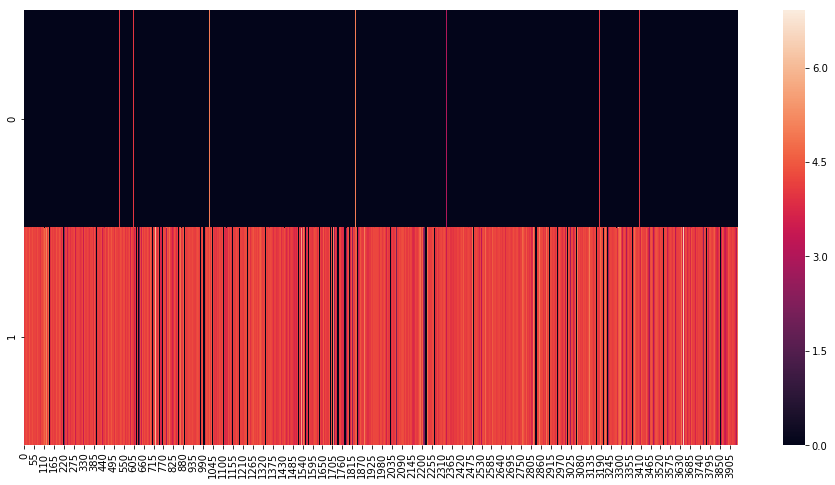

In [35]:
plt.figure(figsize=(16,8))
# sns.heatmap(u)
shape = u.shape
shape_item = shape[0]

u = np.append(u, pred, axis=0).reshape((2, shape_item))
sns.heatmap(u)

In [37]:
u[0]

array([5., 0., 0., ..., 0., 0., 0.])

In [42]:
sum((u[0] > 0) * 1)

53

In [53]:
pred

array([4.53179162, 4.15715189, 4.23517744, ..., 4.78494346, 4.26180821,
       4.2860842 ])

In [52]:
np.mean(u[0][(u[0] > 0)])

4.188679245283019